<img align="left" src="imgs/logo.jpg" width="50px" style="margin-right:10px">
# Snorkel Workshop: Extracting Spouse Relations <br> from the News
## Part 3: Training the Generative Model

Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

In [29]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import re
import numpy as np

# Connect to the database backend and initalize a Snorkel session
from lib.init import *
from snorkel.models import candidate_subclass
from snorkel.annotations import load_gold_labels

from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)

# initialize our candidate type definition
Spouse = candidate_subclass('Spouse', ['person1', 'person2'])

# gold (human-labeled) development set labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# I. Loading Labeling Matricies 

First we'll load our label matrices from notebook 2

In [35]:
from snorkel.annotations import LabelAnnotator

labeler = LabelAnnotator(lfs=[])
L_train = labeler.load_matrix(session, split=0)
L_dev   = labeler.load_matrix(session, split=1)

Now we set up and run the hyperparameter search, training our model with different hyperparamters and picking the best model configuration to keep. We'll set the random seed to maintain reproducibility.

Note that we are fitting our model's parameters to the training set generated by our labeling functions, while we are picking hyperparamters with respect to score over the development set labels which we created by hand.

# II: Unifying supervision

## Generative Model
In data programming, we use a more sophisitcated model to unify our labeling functions. We know that these labeling functions will not be perfect, and some may be quite low-quality, so we will _model_ their accuracies with a generative model, which Snorkel will help us easily apply.

This will ultimately produce a single set of **noise-aware training labels**, which we will then use to train an end extraction model in the next notebook.  For more technical details of this overall approach, see our [NIPS 2016 paper](https://arxiv.org/abs/1605.07723).

**NOTE: Make sure you've written some of your own LFs in the previous notebook to get a decent score!!!**

### 1. Training the Model
When training the generative model, we'll tune our hyperparamters using a simple grid search. 

**Parameter Definitions**
    
    epochs     A single pass through all the data in your training set
    step_size  The factor by which we update model weights after computing the gradient
    decay      The rate our update factor dimishes (decay) over time.
    

In [36]:
from snorkel.learning import GenerativeModel
from snorkel.learning import RandomSearch

# use random search to optimize the generative model
param_ranges = {
    'step_size' : [1e-3, 1e-4, 1e-5, 1e-6],
    'decay'     : [0.9, 0.95],
    'epochs'    : [50, 100],
    'reg_param' : [1e-3],
}

model_class_params = {'lf_propensity' : False}

searcher = RandomSearch(GenerativeModel, param_ranges, L_train, n=5, model_class_params=model_class_params)
%time gen_model, run_stats = searcher.fit(L_dev, L_gold_dev)

run_stats

[1] Testing step_size = 1.00e-05, decay = 9.00e-01, epochs = 100, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 0.43617021276595747
[GenerativeModel] Model saved as <GenerativeModel_0>.
[GenerativeModel] Model saved as <GenerativeModel_best>.
[2] Testing step_size = 1.00e-04, decay = 9.00e-01, epochs = 100, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 0.35451505016722407
[3] Testing step_size = 1.00e-05, decay = 9.50e-01, epochs = 50, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 0.4230769230769231
[4] Testing step_size = 1.00e-05, decay = 9.50e-01, epochs = 100, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 0.4230769230769231
[5] Testing step_size = 1.00e-03, decay = 9.00e-01, epochs = 50, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 0.23846153846153842
[GenerativeModel] Model <GenerativeModel_0> loaded.
CPU times: user 4min 24s, sys: 99.9 ms, t

,step_size,decay,epochs,reg_param,Prec.,Rec.,F-1
0,0.00001,0.90,100,0.001,0.438503,0.433862,0.436170
2,0.00001,0.95,50,0.001,0.440000,0.407407,0.423077
3,0.00001,0.95,100,0.001,0.440000,0.407407,0.423077
1,0.00010,0.90,100,0.001,0.481818,0.280423,0.354515
4,0.00100,0.90,50,0.001,0.436620,0.164021,0.238462


### 2. Model Accuracies
These are the weights learned for each LF

In [37]:
x = L_dev.lf_stats(session, L_gold_dev)

In [38]:
train_marginals = gen_model.marginals(L_train)

### 3. Plotting Marginal Probabilities
One immediate santity check  you can peform using the generative model is to visually examine the distribution of predicted training marginals. Ideally, there should get a bimodal distribution with large seperation between each peaks, as shown below by the far right image. The corresponds to good signal for true and positive class labels. For your first Snorkel application, you'll probably see marginals closer to the far left or middle images. With all mass centered around p=0.5, you probably need to write more LFs got get more overall _coverage_. In the middle image, you have good negative coverage, but not enough positive LFs

<img align="left" src="imgs/marginals-common.jpg" width="265px" style="margin-right:0px">

<img align="left" src="imgs/marginals-real.jpg" width="265px" style="margin-right:0px">

<img align="left" src="imgs/marginals-ideal.jpg" width="265px" style="margin-right:0px">


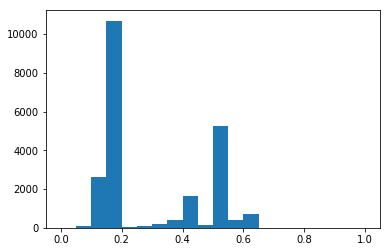

In [39]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20, range=(0.0, 1.0))
plt.show()

### 4. Generative Model Metrics

In [40]:
dev_marginals = gen_model.marginals(L_dev)
_, _, _, _ = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.434
Neg. class accuracy: 0.96
Precision            0.439
Recall               0.434
F1                   0.436
----------------------------------------
TP: 82 | FP: 105 | TN: 2517 | FN: 107



### 5. Saving our training labels

Finally, we'll save the `training_marginals`, which are our **"noise-aware training labels"**, so that we can use them in the next tutorial to train our end extraction model:

In [41]:
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train, train_marginals)

Saved 22254 marginals
CPU times: user 10.8 s, sys: 4.02 ms, total: 10.8 s
Wall time: 10.9 s


# III. Advanced Generative Model Features

## A. Structure Learning

We may also want to include the dependencies between our LFs when training the generative model. Snorkel makes it easy to do this! `DependencySelector` runs a fast structure learning algorithm over the matrix of LF outputs to identify a set of likely dependencies. 

In [42]:
from snorkel.learning.structure import DependencySelector

MAX_DEPS = 5

ds = DependencySelector()
deps = ds.select(L_train, threshold=0.1)
deps = set(list(deps)[0:min(len(deps), MAX_DEPS)])

print("Using {} dependencies".format(len(deps)))

Using 5 dependencies


Now train the generative model with dependencies, we just pass in the above set as the `deps` argument to our model train function.

    searcher = RandomSearch(GenerativeModel, param_grid, L_train, n=4, lf_propensity=False)
    gen_model, run_stats = searcher.fit(L_dev, L_gold_dev, deps=deps)
    run_stats